# 1. Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
import lightgbm as lgb
from sklearn.metrics import f1_score
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
import numpy as np
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [5]:
df = pd.read_csv('toxic_comments.csv')

In [6]:
df = df.drop('Unnamed: 0', axis=1)

Осмотр данных

In [7]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
df.sample()

,text,toxic
133187,This edit looks ok.,0


In [9]:
df.tail()

,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Пропусков нет

Распределение классов

In [10]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Наблюдается дисбаланс классов

Функция для очистки и токенизации текста с помощью регулярных выражений

In [11]:
def clean_re(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
df['text'] = df['text'].map(lambda x : clean_re(x))

Загрузка списка стоп-слов

In [13]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создание переменных для признаков и целевого признака

In [14]:
X = df.drop('toxic', axis=1)
y = df['toxic']

Разделение датасета на обучающую и тестовую выборки в соотношении 70:30

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Обучение и тестирование моделей

Для поиска оптимального значения гиперпараметров использую `GridSearchCV` с кросс-валидацией на трех подвыборках и расчетом TF-IDF для каждой выборки.

#### Логистическая регрессия

In [16]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=42))])

params = {'clf__C': [0.1, 1, 10, 100],
          'clf__class_weight': ['balanced', None]}

grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid.fit(X_train['text'], y_train)
grid.best_params_

{'clf__C': 10, 'clf__class_weight': 'balanced'}

#### Наивный байесовский классификатор (Бернулли)

In [17]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', BernoulliNB())])

params = {
  'clf__alpha': [0.5, 0.8, 1],
  'clf__binarize': [0.0, 0.02, 0.05],
  'clf__fit_prior': [True]}

grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid.fit(X_train['text'], y_train)
grid.best_params_

{'clf__alpha': 1, 'clf__binarize': 0.0, 'clf__fit_prior': True}

#### LightGBM

In [18]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', lgb.LGBMClassifier(random_state=42))])

params = {
  'clf__n_estimators': [200],
  'clf__learning_rate': [0.15, 0.25],
  'clf__max_depth': [8, 10, -1]}

grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid.fit(X_train['text'], y_train)
grid.best_params_

{'clf__learning_rate': 0.25, 'clf__max_depth': -1, 'clf__n_estimators': 200}

#### Обучение моделей

Создание счетчика TF-IDF

In [19]:
vect_word = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

Расчет TF-IDF

In [20]:
X_train = vect_word.fit_transform(X_train['text'])
X_test = vect_word.transform(X_test['text'])

Обучение моделей с оптимальными гиперпараметрами

In [22]:
lr_balanced = LogisticRegression(C=10, class_weight='balanced', random_state=42)
lr_balanced.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [23]:
ber = BernoulliNB(alpha=1, binarize=0.0, fit_prior=True)
ber.fit(X_train, y_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [24]:
lgbm = lgb.LGBMClassifier(learning_rate=0.25, max_depth=-1, n_estimators=200, random_state = 42)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.25, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
models = [lr_balanced, ber, lgbm]

Функция для расчета F1-меры и построения графиков. Предсказания на тестовой выборке для обученных моделей.

In [30]:
def f1_scores(models):
    models_list = []
    f1 = []
    for model in models:
        test_predictions = model.predict(X_test)
        f1_valid_score = f1_score(y_test, test_predictions)
        models_list.append(type(model).__name__)
        f1.append(f1_valid_score)
    fig = go.Figure(
    data=[go.Bar(x=models_list, y=f1)],
    layout=dict(title=dict(text="F1-мера")))
    fig.update_layout(autosize=False,width=700,height=350)
    fig.show('png')

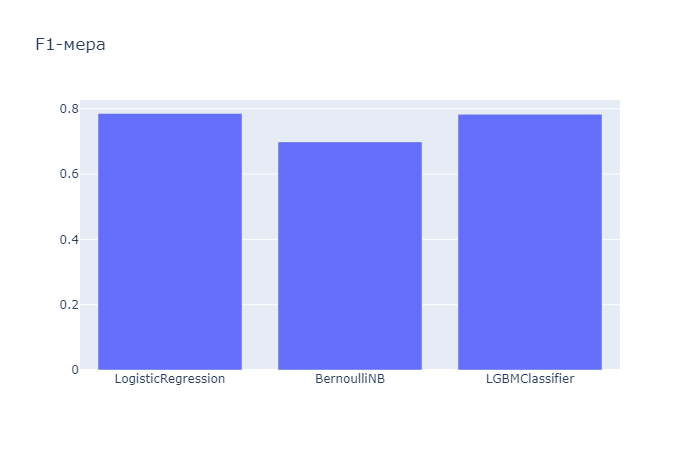

In [31]:
f1_scores(models)

# 3. Выводы

### Вывод
 - На тестовой выборке лучшее значение `F1-меры` 0.785 у `LogisticRegression`. Значение `LGBMClassifier` чуть меньше - 0.783. `LogisticRegression`. Результат `BernoulliNB` 0.698